### 주택 가격 예측 : 회귀문제
--------------------
보스턴 주택 가격 데이터셋: 보스턴 외곽 지역의 범죄율, 지방세율 등의 데이터셋으로, 주어졌을 때 주택 가격의 중간 값을 예측 가능

--------------------

보스턴 주택 가격 데이터셋 특징
- 1) 데이터 포인트가 506개, 404개는 훈련 샘플, 102개는 테스트 샘플
- 2) 입력 데이터에 있는 각 특성은 스케일이 서로 다름
- 3) 어떤 값은 0과 1 사이이 비율을 나타내고, 어떤 것은 1과 12사이의 값을 가지거나 1과 100사이의 값을 가짐

- 보스턴 하우징 로드
- 506개의 데이터 포인트를 가져오고 404개의 훈련 샘플과 102개의 테스트 샘플로 나눈다

In [1]:
import numpy as np
data = np.load('./boston_housing.npz')
from keras.datasets import boston_housing
(train_data, train_targets), (test_data, test_targets)=boston_housing.load_data()

Using TensorFlow backend.


- 입력데이터에 있는 각 특성에 대해서 특성의 평균을 빼고 표준 편차로 나눈다

In [2]:
mean = train_data.mean(axis=0)
train_data -= mean
std = train_data.std(axis=0)
train_data /= std
test_data -= mean
test_data /= std

- 여러번 정의할 목적으로 모델 정의 함수를 만들고 64개 유닛을 가진 2개 층으로 네트워크를 구성

In [3]:
from keras import models
from keras import layers

def build_model():
    model = models.Sequential()
    model.add(layers.Dense(64, activation='relu', input_shape=(train_data.shape[1],)))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(1))
    model.compile(optimizer='rmsprop',loss='mse', metrics=['mae'])
    return model

- K-겹 교차 검증을 사용해 검증
- 데이터를 k개로 분할하고 k개의 모델을 만들어 k-1개의 분할에서 훈련하고 나머지 분할에서 평가한다.

In [4]:
import numpy as np

k = 4
num_val_samples = len(train_data) // k
num_epochs = 100
all_scores = []
for i in range(k):
    print('처리중인 폴드 #', i)
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]

    partial_train_data = np.concatenate(
        [train_data[:i * num_val_samples],
         train_data[(i + 1) * num_val_samples:]],
        axis=0)
    partial_train_targets = np.concatenate(
        [train_targets[:i * num_val_samples],
         train_targets[(i + 1) * num_val_samples:]],
        axis=0)

    model = build_model()
    model.fit(partial_train_data, partial_train_targets,
              epochs=num_epochs, batch_size=1, verbose=0)
    val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=0)
    all_scores.append(val_mae)

처리중인 폴드 # 0
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
처리중인 폴드 # 1
처리중인 폴드 # 2
처리중인 폴드 # 3


- 메모리해제하고
- 각폴드에서 검증 점수를 로그에 저장

In [5]:
from keras import backend as K

K.clear_session()

In [6]:
num_epochs = 500
all_mae_histories = []
for i in range(k):
    print('처리중인 폴드 #', i)
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]


    partial_train_data = np.concatenate(
        [train_data[:i * num_val_samples],
         train_data[(i + 1) * num_val_samples:]],
        axis=0)
    partial_train_targets = np.concatenate(
        [train_targets[:i * num_val_samples],
         train_targets[(i + 1) * num_val_samples:]],
        axis=0)

    model = build_model()
    history = model.fit(partial_train_data, partial_train_targets,
                        validation_data=(val_data, val_targets),
                        epochs=num_epochs, batch_size=1, verbose=0)
    mae_history = history.history['val_mean_absolute_error']
    all_mae_histories.append(mae_history)

처리중인 폴드 # 0
처리중인 폴드 # 1
처리중인 폴드 # 2
처리중인 폴드 # 3


- K-겹 검증 점수 평균을 기록하고 검증 점수 그래프를 그린다

In [7]:
average_mae_history = [np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]

In [8]:
import matplotlib.pyplot as plt
plt.plot(range(1, len(average_mae_history) + 1), average_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

<Figure size 640x480 with 1 Axes>

- 처음 10개의 데이터 포인트를 제외하고 검증 점수를 그린다

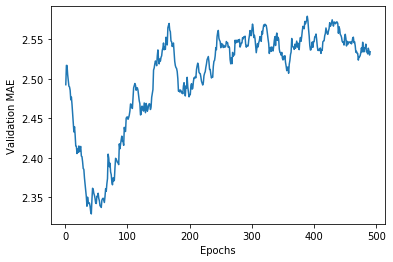

In [9]:
def smooth_curve(points, factor=0.9):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points
smooth_mae_history = smooth_curve(average_mae_history[10:])
plt.plot(range(1, len(smooth_mae_history)+1), smooth_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

- 에포치 80으로하고 전체 데이터 훈련하고 결과값 2.6 확인

In [10]:
model = build_model()
model.fit(train_data, train_targets,
          epochs=80, batch_size=16, verbose=0)
test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)

102/102 [==============================] - 0s 2ms/step


In [11]:
test_mae_score

2.6790533626780793